# **Hyperparameter Tuning**

## Objectives

* Explore effects of hyperparater tuning on model

## Inputs

* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Model performance curve plot
* Model evaluation pickle file

## Additional Comments

* No comments

---

## Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspaces/mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew-detection-in-cherry-leaves'

## Set input directories

In [5]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

---

## Set output directory

In [6]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


## Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Label: {labels}"
    )

Label: ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
## Import saved image shape embedding pickle file
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Importing libraries

In [9]:
from keras.preprocessing.image import load_img,save_img,ImageDataGenerator
from os import listdir
from tensorflow import keras

In [10]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss',patience=3)

In [13]:
def batch_size_effect(opt, batch_size):
  print("Evaluating optimiser" + str(opt) + "batch size " + str(batch_size))
  # prepare iterators
  train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )
  validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

  test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

  # create the model
  model2 = Sequential()
  model2.add(Conv2D(filters=16,kernel_size=(3,3),input_shape=image_shape,activation='relu'))
  model2.add(MaxPooling2D(pool_size=(2,2)))
  model2.add(Conv2D(32,(3,3),activation='relu'))
  model2.add(MaxPooling2D(pool_size=(2,2)))
  model2.add(Conv2D(64,(3,3),activation='relu'))
  model2.add(MaxPooling2D(pool_size=(2,2)))
  model2.add(Flatten())
  model2.add(Dense(64,activation='relu'))
  model2.add(Dropout(0.25))
  model2.add(Dense(1,activation='sigmoid'))
    
  # Compile model
  model2.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
 
  # fit the model
  model2.fit(
        train_set, # pass in the training set
        steps_per_epoch=len(train_set.classes)//batch_size,
        epochs=5,
        validation_data=validation_set, # pass in the validation set
        callbacks=[callback],
        verbose=1
        )

  # evaluate model
  _, acc = model2.evaluate(test_set, steps=len(test_set), verbose=1)
  return acc

## Comparing Adam and SGD optimizers

In [14]:
# set batch size array
batch_sizes_array = [16,32,64,128]

In [15]:
adam_accuracies = []
optimizer = "adam"
for bs in batch_sizes_array:
  adam_accuracies.append(batch_size_effect(optimizer, bs))

sgd_accuracies = []
optimizer = "sgd"
for bs in batch_sizes_array:
  sgd_accuracies.append(batch_size_effect(optimizer, bs))

Evaluating optimiseradambatch size 16
Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 844 images belonging to 2 classes.


2023-07-18 08:46:51.831896: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 08:46:54.763448: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
184/184 [==============================] - 190s 995ms/step - loss: 0.2010 - accuracy: 0.9161 - val_loss: 0.0597 - val_accuracy: 0.9833
Epoch 2/5
184/184 [==============================] - 178s 963ms/step - loss: 0.0817 - accuracy: 0.9688 - val_loss: 0.0242 - val_accuracy: 0.9929
Epoch 3/5
184/184 [==============================] - 176s 952ms/step - loss: 0.0297 - accuracy: 0.9918 - val_loss: 0.0213 - val_accuracy: 0.9952
Epoch 4/5
184/184 [==============================] - 178s 964ms/step - loss: 0.0318 - accuracy: 0.9891 - val_loss: 0.0180 - val_accuracy: 0.9952
Epoch 5/5
53/53 [==============================] - 13s 243ms/step - loss: 0.0073 - accuracy: 0.9988
Evaluating optimiseradambatch size 32
Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 844 images belonging to 2 classes.
Epoch 1/5
92/92 [==============================] - 188s 2s/step - loss: 0.4082 - accuracy: 0.7887 - val_loss: 0.0341 - val_accuracy: 0.9929
Epoch 2/5
92/92 [=

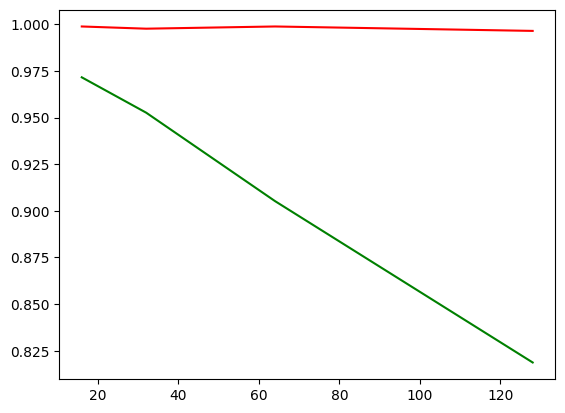

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
plt.plot(batch_sizes_array, adam_accuracies, color='red',label='Adam')
plt.plot(batch_sizes_array, sgd_accuracies, color='green',label='SGD')
plt.show()

plt.savefig('batch_size_accuracies.png')

# Push files to Repo

In [ ]:
!git add .

---